In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import random as rnd
from random import uniform as uniform
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import zipfile
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle/'

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Kaggle/

!kaggle datasets download -d cactus3/basicshapes --force

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Kaggle/basicshapes.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

!ls '/tmp/shapes'

/content/drive/MyDrive/Kaggle
100% 402k/402k [00:00<00:00, 772kB/s]
100% 402k/402k [00:00<00:00, 769kB/s]
circles  shapes  squares  triangles


In [47]:
from PIL import Image
path = '/tmp/shapes'
first_path = path + '/triangles'
second_path = path + '/squares'
pathes = [first_path, second_path]

y_values = [[1], [0]]

x = []
y = []

size = (8, 8)

max_count = 20+10

for i in range(len(pathes)):
  count = 0
  files = os.listdir(pathes[i])
  np.random.shuffle(files)
  for j in files:
    im = Image.open(pathes[i] + '/' + j)
    im = im.resize(size, Image.ANTIALIAS).convert('L')
    im = np.asarray(im) / 250
    count += 1

    x.append(im)
    y.append(y_values[i])

    if count == max_count:
      break

In [48]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

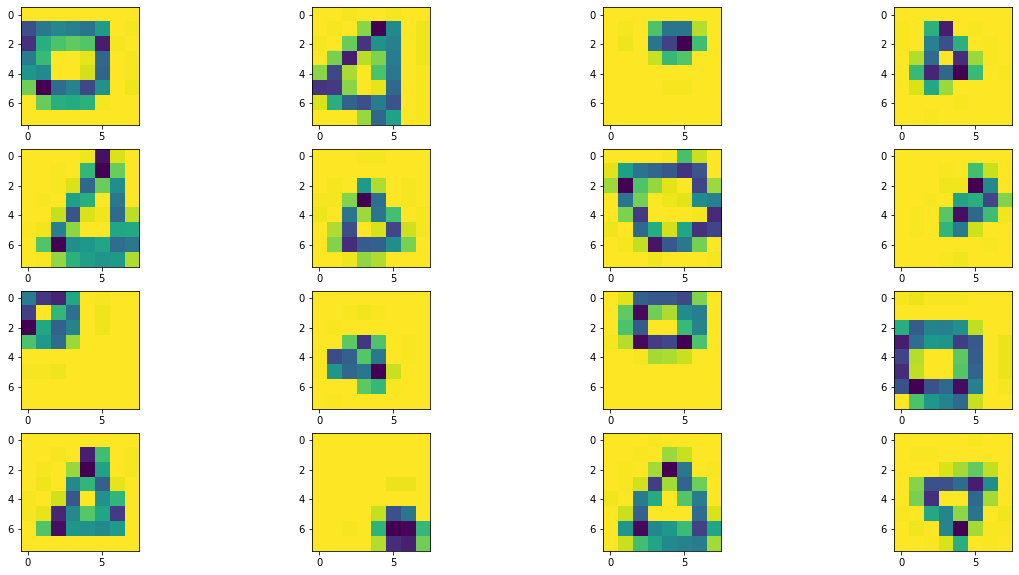

In [49]:
rows = 4
cols = 4

plt.figure(figsize = (20, 10))
for i in range(rows):
  for j in range(cols):
    plt.subplot(rows, cols, j + rows * i + 1)
    plt.imshow(x_train[j + rows * i])

In [50]:
def get_reshaped(arr):
  for i in range(len(arr)):
    arr[i] = arr[i].reshape([-1])
    arr[i] = np.append(arr[i], 1)
  return arr

In [51]:
def act(x):
  return 1 / (1 + math.pow(math.e, -x))

def deriv(x):
  return act(x) * (1 - act(x))

In [52]:
def full_batch(x_arr, y_arr):
  return x_arr, y_arr

In [53]:
def get_weights_copy(weights):
  w = []
  for l in range(len(weights)):
    w.append([])
    for n in range(len(weights[l])):
      w[l].append([])
      for s in range(len(weights[l][n])):
        w[l][n].append(weights[l][n][s])

  return w

def get_random_weight():
  return uniform(-0.5, 0.5)

def get_weights(input_count, shapes):
  weights = []

  weights.append([])
  for i in range(shapes[0]):
    weights[0].append([])
    for j in range(input_count - 1):
      weights[0][i].append(get_random_weight())
    weights[0][i].append(get_random_weight())
  
  for i in range(1, len(shapes) - 1):
    weights.append([])
    for j in range(shapes[i]):
      weights[i].append([])
      for k in range(len(weights[i - 1])):
        weights[i][j].append(get_random_weight())
      weights[i][j].append(get_random_weight())

  last = shapes[len(shapes) - 1]

  for l in range(1, len(weights) - 1):
    b = 0.7 * ((len(weights[l]) - 1) ** (1 / len(weights[i - 1])))
    for n in range(len(weights[l])):
      n_sum = np.sum(weights[l][n])
      for i in range(len(weights[l][n])):
        weights[l][n][i] = b * weights[l][n][i] / n_sum

  weights.append([])
  l = len(shapes) - 1
  for j in range(last):
      weights[l].append([])
      b = 0.7 * ((last) ** (1 / len(weights[l - 1])))
      for k in range(len(weights[l - 1])):
        weights[l][j].append(uniform(-b, b))
      weights[l][j].append(uniform(-b, b))

  return weights

def out_weights(w):
  print()
  for i in range(len(w)):
    print(f'layer {i + 1}')
    for j in range(len(w[i])):
      print(f'neuron {j + 1}: {w[i][j]}')
  print()

In [66]:
def predict(weights, signals, act):
  fields = []
  signals_layers = []

  fields.append([])

  for k in signals:
    fields[0].append(k)

  fields.append([])
  signals_layers.append([])
  #print(fields[0])
  for j in range(len(weights[0])):
    f = np.dot(weights[0][j], fields[0])
    #print(weights[0][j])
    #print(fields[0])
    fields[1].append(f)
    signals_layers[0].append(act(f))

  if (len(weights) > 1):
    fields[1].append(1)
    signals_layers[0].append(1)

    for i in range(1, len(weights)):
      fields.append([])
      signals_layers.append([])
      for j in range(len(weights[i])):
        f = np.dot(weights[i][j], signals_layers[i - 1])
        fields[i + 1].append(f)
        signals_layers[i].append(act(f))
      if (i != len(weights) - 1):
        fields[i + 1].append(1)
        signals_layers[i].append(1)

  return signals_layers[len(signals_layers) - 1], fields

def back_prop(weights, x_train, y_train, batch_func, act, deriv, max_sq_error, max_epochs, train_speed):
  G = []
  for i in range(len(weights)):
    G.append([])
    for j in range(len(weights[i])):
      G[i].append(0)

  epochs = 0
  errs = 0
  errs_out = []
  decrease_count = 0
  while(True):
    epochs += 1

    print(f'epoch {epochs} has started', end='')

    errs = 0

    x_train_now, y_train_now = batch_func(x_train, y_train)

    for i_x in range(len(x_train_now)):
      predicted = predict(weights, x_train_now[i_x], act)

      y_pr = predicted[0]
      fields = predicted[1]

      L = len(weights) - 1

      for i in range(len(y_pr)):
        error = y_train_now[i_x][i] - y_pr[i]
        errs += error ** 2

        g = deriv(fields[L + 1][i]) * error
        G[L][i] = g
        weights[L][0][i] += train_speed * g * act(fields[L][i])

      for i in range(L - 1, -1, -1):
        for j in range(len(weights[i])):

          weighted_sum = 0
          for k in range(len(weights[i + 1])):
            weighted_sum += weights[i + 1][k][j] * G[i + 1][k]
            #print(f'i = {i}, j = {j}, k = {k}')
                             
          g = deriv(fields[i + 1][j]) * weighted_sum
          G[i][j] = g         

          for k in range(len(weights[i][j])):
            weights[i][j][k] += train_speed * g * act(fields[i][k])

    errs = errs ** 0.5

    errs_out.append(errs)

    print(f', sq err = {errs}')

    if (errs <= max_sq_error):
      print(f'epochs: {epochs}, squared error = {errs}')
      break

    if (epochs == max_epochs):
      print(f'epoch limited. epochs: {epochs}, squared error = {errs}')
      break

  return weights, errs_out

In [64]:
def fit(weights, x_train, y_train, epochs, train_speed, max_error):
  errs_out = []
  for epoch in range(epochs):

    print(f'epoch {epoch + 1} has started', end=', ')

    errs = 0

    for i in range(len(x_train)):
      
      pr = predict(weights, x_train[i], act)
      y_pr = pr[0][0]
      signals_hidden = pr[1]
      net_k = signals_hidden[1][0]

      err = y_train[i][0] - y_pr
      errs += err ** 2

      sigma_o = train_speed * err * deriv(net_k)

      for j in range(len(weights[1][0])):
        weights[1][0][j] += sigma_o * signals_hidden[1][j]

      for j in range(len(weights[0])):

        net_j = np.dot(weights[0][j], x_train[i])
        der = train_speed * deriv(net_j)

        for k in range(len(weights[0][j])):
          weights[0][j][k] += der * x_train[i][k] * sigma_o * weights[1][0][j]

    errs = errs ** 0.5
    errs_out.append(errs)
    print(f'squared error = {errs}')

    if (errs <= max_error):
      print('fitting is done')
      break

  return weights, errs_out

In [56]:
def get_mse(weights, x_test, y_test, act_func, pred_func):
  prs = []
  for i in range(len(x_test)):
    prs.append(pred_func(weights, x_test[i], act_func)[0])
  mse = np.square(np.array(prs) - np.array(y_test)).mean()
  return mse

In [57]:
x_train = get_reshaped(x_train)
x_test = get_reshaped(x_test)

print(f'shapes {x_test[0].shape}')

shapes (65,)


In [58]:
inputs = len(x_train[0])

layers = [36, 1]

weights = get_weights(inputs, layers)
w_delta = get_weights_copy(weights)
w_back_prop = get_weights_copy(weights)

In [59]:
result_delta = fit(w_delta, x_train, y_train, 3000, 1, 0.3)
w_delta = result_delta[0]
errs_delta = result_delta[1]

epoch 1 has started, squared error = 3.8635878644075166
epoch 2 has started, squared error = 3.79181273085745
epoch 3 has started, squared error = 3.7698228669972895
epoch 4 has started, squared error = 3.7538059225619285
epoch 5 has started, squared error = 3.7391216801594322
epoch 6 has started, squared error = 3.7247742840082183
epoch 7 has started, squared error = 3.710453539917971
epoch 8 has started, squared error = 3.696043551444244
epoch 9 has started, squared error = 3.681501756568775
epoch 10 has started, squared error = 3.6668184569399886
epoch 11 has started, squared error = 3.6519993668976345
epoch 12 has started, squared error = 3.637057421508525
epoch 13 has started, squared error = 3.6220092097693257
epoch 14 has started, squared error = 3.6068730530211965
epoch 15 has started, squared error = 3.59166673944687
epoch 16 has started, squared error = 3.576404510455015
epoch 17 has started, squared error = 3.5610943208992465
epoch 18 has started, squared error = 3.545736799

In [84]:
w_back_prop = get_weights_copy(weights)

In [85]:
result_back_prop = back_prop(w_back_prop, x_train, y_train, full_batch, act, deriv, 0.2+0.1, 4000, 0.3)
w_back_prop = result_back_prop[0]
errs_back_prop = result_back_prop[1]

epoch 1 has started, sq err = 3.668577953981594
epoch 2 has started, sq err = 3.6159182504499157
epoch 3 has started, sq err = 3.58119148800933
epoch 4 has started, sq err = 3.555831850113466
epoch 5 has started, sq err = 3.5360130220850605
epoch 6 has started, sq err = 3.5201469352185777
epoch 7 has started, sq err = 3.5078749478272866
epoch 8 has started, sq err = 3.49848313032432
epoch 9 has started, sq err = 3.4911696650357302
epoch 10 has started, sq err = 3.4853256832182016
epoch 11 has started, sq err = 3.480542016846867
epoch 12 has started, sq err = 3.4765455578815314
epoch 13 has started, sq err = 3.4731482768208
epoch 14 has started, sq err = 3.4702159962187467
epoch 15 has started, sq err = 3.4676499453114316
epoch 16 has started, sq err = 3.4653755145884944
epoch 17 has started, sq err = 3.463335087704199
epoch 18 has started, sq err = 3.4614832967248153
epoch 19 has started, sq err = 3.4597837926065824
epoch 20 has started, sq err = 3.458207001109816
epoch 21 has started,

In [86]:
print(f'mse delta rule = {get_mse(w_delta, x_test, y_test, act, predict)}')
print(f'mse back_prop rule = {get_mse(w_back_prop, x_test, y_test, act, predict)}')

mse delta rule = 0.23314108930758995
mse back_prop rule = 0.2541545020441333


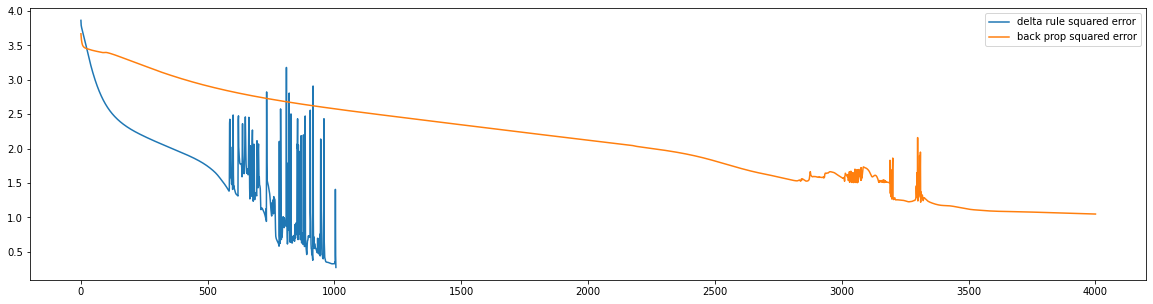

In [87]:
plt.figure(figsize = (20, 5))
plt.plot(range(1, len(errs_delta) + 1), errs_delta, label='delta rule squared error')
plt.plot(range(1, len(errs_back_prop) + 1), errs_back_prop, label='back prop squared error')
plt.legend()